# Recurrent Neural Net Scratch Implementation
### Created by Rahul Shah

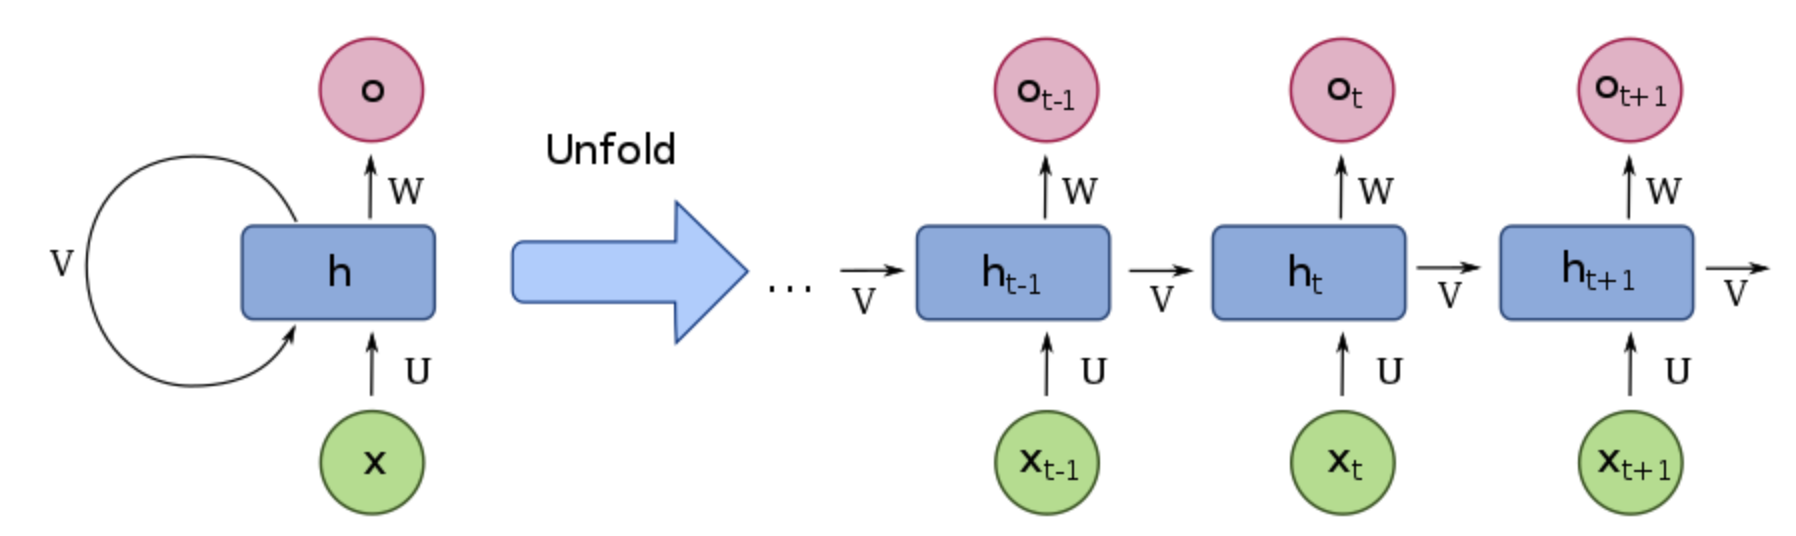


Recurrent Neural Nets are not too different than traditional Dense Networks. The main difference is that theres a second input, which is the previous hidden state. 

**RNN structure:**

3 weight matrices:
  * W_i =  weight matrix thats multiplied with the input at time step t
  * W_h weight matrix thats multiplied with the previous hidden state
  * W_o weight matrix thats multiplied with the current hidden state, returns the output

Hidden State:
  * H_t = tanh( (W_h * H_t-1) + (W_i * H_i) + bias)

Output Vector:
  * output = tanh(H_t * W_o + bias)


#Imports

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

#Prepare Dataset


*   For this implementation, I will train the RNN to predict a Sine Wave



Create Sine Wave

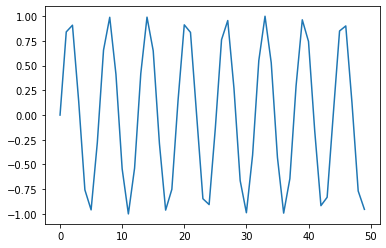

In [2]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])
plt.plot(sin_wave[:50])

Create Dataset

In [3]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - seq_len):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

Verify Dataset shape

In [4]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

Create Validation Set

In [5]:
X_val = []
Y_val = []

for i in range(num_records - 20, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

#Implement RNN

In [208]:
class RNN():
  def __init__(self, input_len, num_examples, output_len, hidden_len, learning_rate):
    self.learning_rate = learning_rate
    #initialize input vector
    self.input = np.random.rand(input_len)
    #initialize weight matrices
    self.W_i = np.random.rand(hidden_len, input_len)
    self.W_h = np.random.rand(hidden_len,hidden_len)
    self.W_o = np.random.rand(output_len, hidden_len)
    #initialize current and previous hidden states
    self.current_hidden_state = np.zeros((hidden_len,1)) #technically you can just cache prev_H and update it during each forward pass. I am doing it this way for clarity's sake
    self.prev_hidden_state = np.zeros((hidden_len,1))
    #initialize biases
    self.hidden_bias = np.ones((hidden_len, 1))
    self.output_bias = np.ones((output_len, 1))
    #initialize cache. This cache contains everything you need for backprop. 
    self.cache = [[self.input, self.W_i, self.W_h, self.W_o, self.current_hidden_state, self.prev_hidden_state]]

  def forward_pass(self, input):
    #Calculate the dot product between your input and W_i
    input_times_W_i = np.dot(self.W_i, input)
    #Calculate the dot product between the previous hidden state and W_h
    prev_hidden_times_W_h = np.dot(self.W_h, self.prev_hidden_state)
    #Calculate the new hidden state
    self.current_hidden_state = np.tanh(prev_hidden_times_W_h + input_times_W_i + self.hidden_bias)
    #Calculate output
    output = np.tanh(np.sum(np.dot(self.current_hidden_state, self.W_o) + self.output_bias))
    #Update input
    self.input = input
    #Append state information to cache
    self.cache.append([self.input, self.W_i, self.W_h, self.W_o, self.current_hidden_state, self.prev_hidden_state])
    #Update hidden states
    self.prev_hidden_state = self.current_hidden_state
    self.current_hidden_state = np.zeros(self.current_hidden_state.shape)
    return output

  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  def sigmoid_derivative(self, output):
    return output * (1 - output)

  def tanh_derivative(self, output):
        return 1-output**2

  def backward_pass(self, output, expected_output):
    #retreive data from cache
    input = self.cache[-1][0]
    W_i = self.cache[-1][1]
    W_h = self.cache[-1][2]
    W_o = self.cache[-1][3]
    prev_hidden_state = self.current_hidden_state
    current_hidden_state = self.prev_hidden_state

    #partial derivative of loss function WRT output
    d_loss_WRT_output = (output - expected_output)
    #partial derivative of tanh WRT output
    d_tanh_WRT_output = self.tanh_derivative(output)
    #partial derivative of tanh output WRT W_h
    d_tanh_output_WRT_W_h = self.tanh_derivative(current_hidden_state)
    #partial derivative of tanh input WRT W_o
    d_input_WRT_W_o = current_hidden_state
    #partial derivative of current_hidden_state WRT W_i
    d_currentH_WRT_W_i = input
    #calculate 3 weight delta matrices: W_o_deltas, W_h_deltas, W_i_deltas
    W_o_deltas = self.learning_rate  * d_loss_WRT_output *  d_tanh_WRT_output * d_tanh_output_WRT_W_h * d_input_WRT_W_o 
    W_h_deltas = np.dot((self.learning_rate  * d_loss_WRT_output * d_tanh_WRT_output * d_tanh_output_WRT_W_h * d_input_WRT_W_o), prev_hidden_state.T)
    W_i_deltas = np.dot(input, (self.learning_rate  * d_loss_WRT_output * d_tanh_WRT_output * d_tanh_output_WRT_W_h * d_input_WRT_W_o).T)
    """print(W_i_deltas.shape)
    print(self.W_i.shape)"""
    #update weights
    self.W_o -= W_o_deltas.T
    self.W_h -= W_h_deltas
    self.W_i += W_i_deltas.T



#Train RNN

In [234]:
NUM_EPOCHS = 30
TIMESTEPS = 50
rnn = RNN(input_len=50, num_examples=1, output_len=1, hidden_len=1, learning_rate = 0.04)
for epoch in range(NUM_EPOCHS):
  loss = 0.0
  for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    new_input = np.zeros(x.shape)
    for t in range(TIMESTEPS):
      new_input[t] = x[t]  
      output = rnn.forward_pass(new_input)
      rnn.backward_pass(output, y)
      loss_per_record = (y - output)**2 / 2
      loss += loss_per_record
  loss = loss / float(Y.shape[0])
  print("Loss: ", loss)

Loss:  [9.83383143]
Loss:  [4.14732938]
Loss:  [3.92253004]
Loss:  [3.94164774]
Loss:  [4.03685587]
Loss:  [4.12587021]
Loss:  [4.1884611]
Loss:  [4.24320932]
Loss:  [4.32368456]
Loss:  [4.39210153]
Loss:  [4.42850638]
Loss:  [4.44808125]
Loss:  [4.46072947]
Loss:  [4.47022235]
Loss:  [4.4793514]
Loss:  [4.49150439]
Loss:  [4.50885549]
Loss:  [4.53100875]
Loss:  [4.55587083]
Loss:  [4.5812145]
Loss:  [4.60553503]
Loss:  [4.62807327]
Loss:  [4.64847021]
Loss:  [4.66640038]
Loss:  [4.68131786]
Loss:  [4.69243367]
Loss:  [4.69905574]
Loss:  [4.70116613]
Loss:  [4.69975835]
Loss:  [4.6965925]


#Test RNN

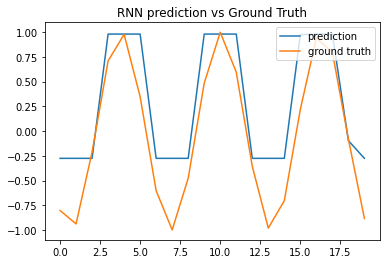

In [240]:
#test the neural net on validation set
x = []
y = []
for i in range(20):
  x.append(i)
  output = rnn.forward_pass(X_val[i])
  y.append(output)
#plot nn prediction and validation set
plt.plot(x,y, label="prediction")
plt.plot(Y_val[:20], label="ground truth")
plt.title("RNN prediction vs Ground Truth")
leg = plt.legend(loc='upper right')
plt.show()